In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15
superaquecimento = 5

# Função para calcular COP, UA, Ad e N2
def calcular_COP_e_UA(P_sep, P_6):
    # Ponto 1
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_sep, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_sep, 'H', h_2, refri2)

    # Ponto 3 (saída do separador)
    h_3 = CP.PropsSI('H', 'P', P_sep, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_sep, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (antes do comp2)
    h_5 = CP.PropsSI('H', 'P', P_sep, 'Q', 1, refri2)
    s_5 = CP.PropsSI('S', 'P', P_sep, 'Q', 1, refri2)

    # Ponto 6 (depois do comp2)
    h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri2)
    h_6 = ((h_6s - h_5) / efi) + h_5
    Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri2)
    s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri2)

    # Ponto 7 (saída do trocador cascata)
    P_7 = P_6
    h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri2)
    Temperatura_7 = CP.PropsSI('T', 'P', P_7, 'Q', 0, refri2)
    s_7 = CP.PropsSI('S', 'P', P_7, 'Q', 0, refri2)

    # Ponto 8
    h_8 = h_7

    # Ponto 9
    Temperatura_9 = Temperatura_7 - delta_T
    h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
    P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
    s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)

    # Ponto 10
    Temperatura_10 = Temperatura_9 + superaquecimento
    P_10 = P_9
    h_10 = CP.PropsSI('H', 'P', P_10, 'T', Temperatura_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_10, 'T', Temperatura_10, refri1)

    # Ponto 12
    P_12 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_12 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 11
    P_11 = P_12
    h_11s = CP.PropsSI('H', 'P', P_11, 'S', s_10, refri1)
    h_11 = ((h_11s - h_10) / efi) + h_10

    # Ponto 13
    h_13 = h_12 + h_9 - h_10

    # Ponto 14
    P_14 = P_9
    h_14 = h_13
    Temperatura_14 = CP.PropsSI('T', 'P', P_14, 'H', h_14, refri1)
    s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
    m3 = m2 * ((h_6 - h_7) / (h_9 - h_14))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    w3 = m3 * (h_11 - h_10)
    COP = carga_termica / (w1 + w2 + w3)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_6 - Temperatura_14) - (Temperatura_7 - Temperatura_9)) /
                 np.log((Temperatura_6 - Temperatura_14) / (Temperatura_7 - Temperatura_9)))

    # Cálculo de Q
    Q = m3 * (h_9 - h_14)  # Calor trocado no ciclo superior

    # Informações do ciclo
    t0 = 30 + 273.15
    tl = -16 + 273.15
    ADTotal = (w1+w2+w3)+(carga_termica*(1-(t0/tl)))

    # Cálculo de UA
    UA = Q / delta_T_m

    return COP, UA, ADTotal

# Função objetivo para o PSO
def funcao_objetivo(x):
    P_sep, P_6 = x[:, 0], x[:, 1]
    COP_valores = np.array([-calcular_COP_e_UA(P_sep[i], P_6[i])[0] for i in range(len(P_sep))])
    return COP_valores

# Limites de busca
Psep_min, Psep_max = 106399, 1330000  # Limites para Psep
P6_min, P6_max = Psep_min, 1330000  # Limites para P6
limites = (np.array([Psep_min, P6_min]), np.array([Psep_max, P6_max]))

# Configuração do PSO
opcoes = {'c1': 2, 'c2': 2, 'w': 1}
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=2, options=opcoes, bounds=limites)

# Execução do PSO
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=40)

# Resultados
Psep_otimizado, P6_otimizado = melhor_posicao
COP_otimizado, UA_otimizado, ADtot = calcular_COP_e_UA(Psep_otimizado, P6_otimizado)

print(f"Resultados ótimos:")
print(f"Psep = {Psep_otimizado / 1000:.2f} kPa")
print(f"P6 = {P6_otimizado / 1000:.2f} kPa")
print(f"COP = {COP_otimizado}")
print(f"UA = {UA_otimizado}")
print(f"ADtot = {ADtot / 1:.2f} W")

2025-03-18 03:27:10,703 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 2, 'c2': 2, 'w': 1}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.7
2025-03-18 03:27:15,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7038888758117428, best pos: [ 413644.85530881 1046516.42638814]


Resultados ótimos:
Psep = 413.64 kPa
P6 = 1046.52 kPa
COP = 1.7038888758117428
UA = 189.7599058499438
ADtot = 498.59 W


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Parâmetros do sistema de refrigeração
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15
T_evap = -25 + 273.15
superaquecimento = 5
tl = -16 + 273.15
efi = 0.7
P_sep = 413600
P_6 = 1046500

# Dados do estado "0"
t0 = 30 + 273.15  # Temperatura ambiente em K
h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

# Ponto 1
h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

# Ponto 2 (saída do compressor 1)
h_2s = CP.PropsSI('H', 'P', P_sep, 'S', s_1, refri2)
h_2 = ((h_2s - h_1) / efi) + h_1
Temperatura_2 = CP.PropsSI('T', 'P', P_sep, 'H', h_2, refri2)
s_2 = CP.PropsSI('S', 'P', P_sep, 'H', h_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

# Ponto 3 (saída do separador)
h_3 = CP.PropsSI('H', 'P', P_sep, 'Q', 0, refri2)
s_3 = CP.PropsSI('S', 'P', P_sep, 'Q', 0, refri2)
Temperatura_3 = CP.PropsSI('T', 'P', P_sep, 'Q', 0, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

# Ponto 4 (saída da válvula inferior)
h_4 = h_3
P_4 = P_1
s_4 = CP.PropsSI('S', 'P', P_4, 'H', h_4, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

# Ponto 5 (antes do comp2)
h_5 = CP.PropsSI('H', 'P', P_sep, 'Q', 1, refri2)
s_5 = CP.PropsSI('S', 'P', P_sep, 'Q', 1, refri2)
P_5 = CP.PropsSI('P', 'P', P_sep, 'Q', 1, refri2)
af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

# Ponto 6 (depois do comp2)
h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri2)
h_6 = ((h_6s - h_5) / efi) + h_5
Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri2)
s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri2)
af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

# Ponto 7 (saída do trocador cascata)
P_7 = P_6
h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri2)
Temperatura_7 = CP.PropsSI('T', 'P', P_7, 'Q', 0, refri2)
s_7 = CP.PropsSI('S', 'P', P_7, 'Q', 0, refri2)
af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))

# Ponto 8
h_8 = h_7
P_8 = P_5
s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri2)
af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))

# Ponto 9
Temperatura_9 = Temperatura_7 - delta_T
h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

# Ponto 10
Temperatura_10 = Temperatura_9 + 5
P_10 = P_9
h_10 = CP.PropsSI('H', 'P', P_10, 'T', Temperatura_10, refri1)
s_10 = CP.PropsSI('S', 'P', P_10, 'T', Temperatura_10, refri1)
af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

# Ponto 12
P_12 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_12 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_12 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

# Ponto 11
P_11 = P_12
h_11s = CP.PropsSI('H', 'P', P_11, 'S', s_10, refri1)
h_11 = ((h_11s - h_10) / efi) + h_10
s_11 = CP.PropsSI('S', 'P', P_11, 'H', h_11, refri1)
af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

# Ponto 13
h_13 = h_12 + h_9 - h_10
P_13 = P_12
s_13 = CP.PropsSI('S', 'P', P_13, 'H', h_13, refri1)
af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

# Ponto 14
P_14 = P_9
h_14 = h_13
Temperatura_14 = CP.PropsSI('T', 'P', P_14, 'H', h_14, refri1)
s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))

# Cálculo das vazões mássicas
m1 = carga_termica / (h_1 - h_4)
m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
m3 = m2 * ((h_6 - h_7) / (h_9 - h_14))

# Trabalhos e COP
w1 = m1 * (h_2 - h_1)
w2 = m2 * (h_6 - h_5)
w3 = m3 * (h_11 - h_10)
COP = carga_termica / (w1 + w2 + w3)

# Cálculo da diferença de temperatura média logarítmica (LMTD)
delta_T_m = (((Temperatura_6 - Temperatura_14) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_14) / (Temperatura_7 - Temperatura_9)))

# Cálculo de Q
Q = m3 * (h_9 - h_14)  # Calor trocado no ciclo superior

# Cálculo de UA
UA = Q / delta_T_m

# Destruicoes de exergia
ADComp1 = (m1*af1)+w1-(m1*af2)
ADValv1 = m1*(af3-af4)
ADEvap = (m1*af4)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADSep = (m1*(af2-af3))+(m2*(af8-af5))
ADComp2 = (m2*af5)+w2-(m2*af6)
ADValv2 = m2*(af7-af8)
ADTrocCasc = (m2*(af6-af7))+(m3*(af14-af9))
ADTrocInt = m3*(af9+af12-af13-af10)
ADComp3 = (m3*af10)+w3-(m3*af11)
ADCond = (m3*(af11-af12))
ADValv3 = m3*(af13-af14)

# Informações do ciclo
ADTotal = (w1+w2+w3)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

print(round(ADComp1, 1))
print(round(ADSep, 1))
print(round(ADValv1, 1))
print(round(ADEvap, 1))
print(round(ADComp2, 1))
print(round(ADTrocCasc, 1))
print(round(ADValv2, 1))
print(round(ADTrocInt, 1))
print(round(ADComp3, 1))
print(round(ADValv3, 1))
print(round(ADCond, 1))

print(round(ADTotal, 1))
print(ADComp1+ADSep+ADValv1+ADEvap+ADComp2+ADTrocCasc+ADValv2+ADTrocInt+ADComp3+ADValv3+ADCond)

87.2
4.9
28.4
52.2
80.2
30.8
31.1
3.3
41.0
15.6
123.9
498.6
498.58658514168485


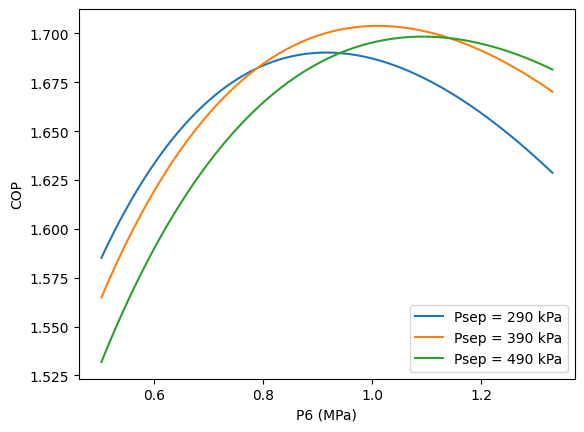

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
T_evap = -25+273.15

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [290000, 390000, 490000]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(504450, 1330000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_COP = []
    pressoes_p6 = []
    for P_6 in valores_de_P6:
        # Dados do estado "0"
        t0 = 30 + 273.15  # Temperatura ambiente em K
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)
        # Ponto 1
        h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

        # Ponto 2 (saída do compressor 1)
        h_2s = CP.PropsSI('H', 'P', P_sep, 'S', s_1, refri2)
        h_2 = ((h_2s - h_1) / efi) + h_1
        Temperatura_2 = CP.PropsSI('T', 'P', P_sep, 'H', h_2, refri2)
        s_2 = CP.PropsSI('S', 'P', P_sep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

        # Ponto 3 (saída do separador)
        h_3 = CP.PropsSI('H', 'P', P_sep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', P_sep, 'Q', 0, refri2)
        Temperatura_3 = CP.PropsSI('T', 'P', P_sep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

        # Ponto 4 (saída da válvula inferior)
        h_4 = h_3
        P_4 = P_1
        s_4 = CP.PropsSI('S', 'P', P_4, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

        # Ponto 5 (antes do comp2)
        h_5 = CP.PropsSI('H', 'P', P_sep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', P_sep, 'Q', 1, refri2)
        P_5 = CP.PropsSI('P', 'P', P_sep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

        # Ponto 6 (depois do comp2)
        h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri2)
        h_6 = ((h_6s - h_5) / efi) + h_5
        Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri2)
        s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

        # Ponto 7 (saída do trocador cascata)
        P_7 = P_6
        h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P_7, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P_7, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))

        # Ponto 8
        h_8 = h_7
        P_8 = P_5
        s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))

        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

        # Ponto 10
        Temperatura_10 = Temperatura_9 + 5
        P_10 = P_9
        h_10 = CP.PropsSI('H', 'P', P_10, 'T', Temperatura_10, refri1)
        s_10 = CP.PropsSI('S', 'P', P_10, 'T', Temperatura_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

        # Ponto 12
        P_12 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_12 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        s_12 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

        # Ponto 11
        P_11 = P_12
        h_11s = CP.PropsSI('H', 'P', P_11, 'S', s_10, refri1)
        h_11 = ((h_11s - h_10) / efi) + h_10
        s_11 = CP.PropsSI('S', 'P', P_11, 'H', h_11, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

        # Ponto 13
        h_13 = h_12 + h_9 - h_10
        P_13 = P_12
        s_13 = CP.PropsSI('S', 'P', P_13, 'H', h_13, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

        # Ponto 14
        P_14 = P_9
        h_14 = h_13
        Temperatura_14 = CP.PropsSI('T', 'P', P_14, 'H', h_14, refri1)
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))

        # Cálculo das vazões mássicas
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_6 - h_7) / (h_9 - h_14))

        # Trabalhos e COP
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_11 - h_10)
        COP = carga_termica / (w1 + w2 + w3)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_14) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_14) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3 * (h_9 - h_14)  # Calor trocado no ciclo superior

        # Cálculo de UA
        UA = Q / delta_T_m

        # Armazenar os resultados para plotagem
        valores_COP.append(COP)
        pressoes_p6.append(P_6 / 1e6)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_COP, label=f'Psep = {int(P_sep / 1e3)} kPa')

# Configurações do gráfico
plt.xlabel('P6 (MPa)')
plt.ylabel('COP')
plt.legend()
plt.grid(False)
plt.show()

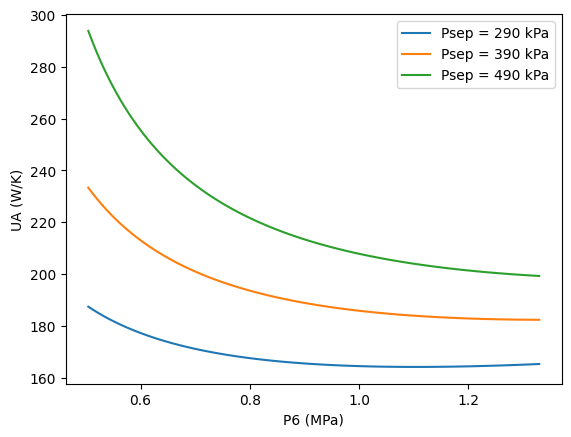

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
tl = -16+273.15

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [290000, 390000, 490000]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(504450, 1330000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_UA = []
    pressoes_p6 = []
    for P_6 in valores_de_P6:
        # Ponto 1
        h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

        # Ponto 2 (saída do compressor 1)
        h_2s = CP.PropsSI('H', 'P', P_sep, 'S', s_1, refri2)
        h_2 = ((h_2s - h_1) / efi) + h_1
        Temperatura_2 = CP.PropsSI('T', 'P', P_sep, 'H', h_2, refri2)
        s_2 = CP.PropsSI('S', 'P', P_sep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

        # Ponto 3 (saída do separador)
        h_3 = CP.PropsSI('H', 'P', P_sep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', P_sep, 'Q', 0, refri2)
        Temperatura_3 = CP.PropsSI('T', 'P', P_sep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

        # Ponto 4 (saída da válvula inferior)
        h_4 = h_3
        P_4 = P_1
        s_4 = CP.PropsSI('S', 'P', P_4, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

        # Ponto 5 (antes do comp2)
        h_5 = CP.PropsSI('H', 'P', P_sep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', P_sep, 'Q', 1, refri2)
        P_5 = CP.PropsSI('P', 'P', P_sep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

        # Ponto 6 (depois do comp2)
        h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri2)
        h_6 = ((h_6s - h_5) / efi) + h_5
        Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri2)
        s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

        # Ponto 7 (saída do trocador cascata)
        P_7 = P_6
        h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P_7, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P_7, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))

        # Ponto 8
        h_8 = h_7
        P_8 = P_5
        s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))

        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

        # Ponto 10
        Temperatura_10 = Temperatura_9 + 5
        P_10 = P_9
        h_10 = CP.PropsSI('H', 'P', P_10, 'T', Temperatura_10, refri1)
        s_10 = CP.PropsSI('S', 'P', P_10, 'T', Temperatura_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

        # Ponto 12
        P_12 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_12 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        s_12 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

        # Ponto 11
        P_11 = P_12
        h_11s = CP.PropsSI('H', 'P', P_11, 'S', s_10, refri1)
        h_11 = ((h_11s - h_10) / efi) + h_10
        s_11 = CP.PropsSI('S', 'P', P_11, 'H', h_11, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

        # Ponto 13
        h_13 = h_12 + h_9 - h_10
        P_13 = P_12
        s_13 = CP.PropsSI('S', 'P', P_13, 'H', h_13, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

        # Ponto 14
        P_14 = P_9
        h_14 = h_13
        Temperatura_14 = CP.PropsSI('T', 'P', P_14, 'H', h_14, refri1)
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
        x14 = CP.PropsSI('Q', 'P', P_14, 'H', h_14, refri1)

        # Cálculo das vazões mássicas
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_6 - h_7) / (h_9 - h_14))

        # Trabalhos e COP
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_11 - h_10)
        COP = carga_termica / (w1 + w2 + w3)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_14) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_14) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3 * (h_9 - h_14)  # Calor trocado no ciclo superior

        # Cálculo de UA
        UA = Q / delta_T_m

        # Armazenar os resultados para plotagem
        valores_UA.append(UA)
        pressoes_p6.append(P_6 / 1e6)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_UA, label=f'Psep = {int(P_sep / 1e3)} kPa')

# Configurações do gráfico
plt.xlabel('P6 (MPa)')
plt.ylabel('UA (W/K)')
plt.legend()
plt.grid(False)
plt.show()

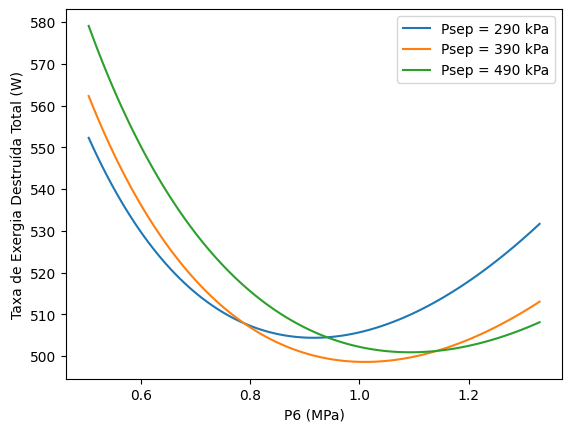

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
tl = -16+273.15
T_evap = -25+273.15

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [290000, 390000, 490000]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(504450, 1330000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_UA = []
    pressoes_p6 = []
    for P_6 in valores_de_P6:
        # Ponto 1
        h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

        # Ponto 2 (saída do compressor 1)
        h_2s = CP.PropsSI('H', 'P', P_sep, 'S', s_1, refri2)
        h_2 = ((h_2s - h_1) / efi) + h_1
        Temperatura_2 = CP.PropsSI('T', 'P', P_sep, 'H', h_2, refri2)
        s_2 = CP.PropsSI('S', 'P', P_sep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

        # Ponto 3 (saída do separador)
        h_3 = CP.PropsSI('H', 'P', P_sep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', P_sep, 'Q', 0, refri2)
        Temperatura_3 = CP.PropsSI('T', 'P', P_sep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

        # Ponto 4 (saída da válvula inferior)
        h_4 = h_3
        P_4 = P_1
        s_4 = CP.PropsSI('S', 'P', P_4, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

        # Ponto 5 (antes do comp2)
        h_5 = CP.PropsSI('H', 'P', P_sep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', P_sep, 'Q', 1, refri2)
        P_5 = CP.PropsSI('P', 'P', P_sep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

        # Ponto 6 (depois do comp2)
        h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri2)
        h_6 = ((h_6s - h_5) / efi) + h_5
        Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri2)
        s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

        # Ponto 7 (saída do trocador cascata)
        P_7 = P_6
        h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P_7, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P_7, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))

        # Ponto 8
        h_8 = h_7
        P_8 = P_5
        s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))

        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

        # Ponto 10
        Temperatura_10 = Temperatura_9 + 5
        P_10 = P_9
        h_10 = CP.PropsSI('H', 'P', P_10, 'T', Temperatura_10, refri1)
        s_10 = CP.PropsSI('S', 'P', P_10, 'T', Temperatura_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

        # Ponto 12
        P_12 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_12 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        s_12 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))

        # Ponto 11
        P_11 = P_12
        h_11s = CP.PropsSI('H', 'P', P_11, 'S', s_10, refri1)
        h_11 = ((h_11s - h_10) / efi) + h_10
        s_11 = CP.PropsSI('S', 'P', P_11, 'H', h_11, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

        # Ponto 13
        h_13 = h_12 + h_9 - h_10
        P_13 = P_12
        s_13 = CP.PropsSI('S', 'P', P_13, 'H', h_13, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))

        # Ponto 14
        P_14 = P_9
        h_14 = h_13
        Temperatura_14 = CP.PropsSI('T', 'P', P_14, 'H', h_14, refri1)
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
        x14 = CP.PropsSI('Q', 'P', P_14, 'H', h_14, refri1)

        # Cálculo das vazões mássicas
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_6 - h_7) / (h_9 - h_14))

        # Trabalhos e COP
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_11 - h_10)
        COP = carga_termica / (w1 + w2 + w3)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_14) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_14) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3 * (h_9 - h_14)  # Calor trocado no ciclo superior

        # Cálculo de UA
        UA = Q / delta_T_m

        # Destruicao de exergia
        t0 = 30 + 273.15  # Temperatura ambiente em K
        tl = -16 + 273.15 # Temperatura do ambiente refrigerado
        ADTot = (w1+w2+w3)+(carga_termica*(1-(t0/tl)))

        # Armazenar os resultados para plotagem
        valores_UA.append(ADTot)
        pressoes_p6.append(P_6 / 1e6)

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_UA, label=f'Psep = {int(P_sep / 1e3)} kPa')

# Configurações do gráfico
plt.xlabel('P6 (MPa)')
plt.ylabel('Taxa de Exergia Destruída Total (W)')
plt.legend()
plt.grid(False)
plt.show()